In [1]:
import os
import sys
sys.path.append('..')
import matplotlib.pyplot as plt

import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict

from datasets.aapmmyo import AAPMMyoDataset

def show_multiple_images(nrows, ncols, images, titles=None, tight=False, cmaps='gray', figsize=None, dpi=None, masks=None):
    num_imgs = len(images)
    num_plots = int(nrows * ncols)
    cmaps = [cmaps] * num_imgs if not isinstance(cmaps, (tuple, list)) else cmaps
    masks = [masks] * num_imgs if not isinstance(masks, (tuple, list)) else masks
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i in range(num_imgs):
        img = images[i].cpu().squeeze() if isinstance(images[i], torch.Tensor) else images[i].squeeze()
        mask = masks[i]
        if mask is not None:
            min_val = img.min()
            img[mask == 0] = min_val
        axes[i].imshow(img, cmap=cmaps[i])
        axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i])
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
    if tight:
        fig.tight_layout()

def filter_suffix_recursive(src_dir, suffix='.png', output_names=False):
    # cannot return filenames instead of full paths?
    suffix = '.' + suffix if '.' not in suffix else suffix
    file_paths = glob.glob(os.path.join(src_dir, '**', '*'+ suffix), recursive=True)
    if output_names:
        file_names = [_.split('/')[-1] for _ in file_paths]
        return sorted(file_paths), sorted(file_names)
    else:
        return sorted(file_paths)

def print_array_info(arr, output=False):
    shapes = []
    data_ranges = []
    if not isinstance(arr, (list, tuple)):
        arr = [arr]

    num_arrs = len(arr)
    for i in range(num_arrs):
        shape = tuple(arr[i].shape)
        data_range = (arr[i].min(), arr[i].max())
        if not output:
            print(f'Shape: {shape}, Range: {data_range}.')
        shapes.append(shape)
        data_ranges.append(data_range)

    if output:
        return shapes, data_ranges

def maybe_mkdir(dir_name):
    os.makedirs(dir_name, exist_ok=True)

# Sample Data Generation

In [2]:
from wrappers.basic_wrapper_v2 import BasicSparseWrapper
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

class DummyNet(BasicSparseWrapper):
    def __init__(self, num_views=None, img_size=256, num_full_views=720, source_distance=1075, det_count=672):
        super().__init__(num_views, img_size, num_full_views, source_distance, det_count)
    
    def forward(self, x):
        return x

def gen_sparse_and_gt_data(net, mu_ct, out='sinogram'):
    net = net.cuda()
    mu_ct = mu_ct.cuda()
    with torch.no_grad():
        if out == 'sinogram':
            sparse, gt = net.generate_sparse_and_full_sinogram(mu_ct)
        else:
            sparse, gt = net.generate_sparse_and_full_ct(mu_ct)
        return sparse.cpu(), gt.cpu()

def gen_different_view_data(mu_ct, num_views, img_size=256):
    net = DummyNet(num_views=num_views, img_size=img_size)
    sparse_sinogram, sinogram = gen_sparse_and_gt_data(net, mu_ct, out='sinogram')
    sparse_image, image = gen_sparse_and_gt_data(net, mu_ct, out='image')
    return image, sinogram, sparse_image, sparse_sinogram

dataset_path = '/mnt/data_jixie1/clma/aapm_tr5410_te526'
img_size = 256
dataset = AAPMMyoDataset(dataset_path, mode='val', dataset_shape=img_size)

dataset:5936, training set:5410, val set:526
finish loading AAPM-myo val dataset, total images 526


full views: 720, sparse views: 18.


/home/clma/miniconda3/envs/rec37/lib/python3.7/site-packages/torch_radon-1.0.0-py3.7-linux-x86_64.egg/torch_radon/__init__.py:96: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  sino_fft = torch.rfft(padded_sinogram, 1, normalized=True, onesided=False)
/home/clma/miniconda3/envs/rec37/lib/python3.7/site-packages/torch_radon-1.0.0-py3.7-linux-x86_64.egg/torch_radon/__init__.py:103: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  filtered_sinogram = torch.irfft(filtered_sino_fft, 1, normalized=Tr

full views: 720, sparse views: 36.
full views: 720, sparse views: 72.
full views: 720, sparse views: 144.
Images shape:  [(1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256)]
Sinograms shape:  [(1, 1, 18, 672), (1, 1, 36, 672), (1, 1, 72, 672), (1, 1, 144, 672), (1, 1, 720, 672)]


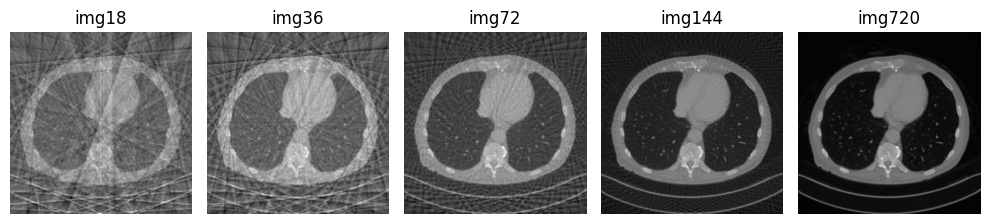

In [3]:
mu = dataset[0].unsqueeze(0)
img720, sino720, img18, sino18 = gen_different_view_data(mu, 18)
_, _, img36, sino36 = gen_different_view_data(mu, 36)
_, _, img72, sino72 = gen_different_view_data(mu, 72)
_, _, img144, sino144 = gen_different_view_data(mu, 144)

img_list = [img18, img36, img72, img144, img720]
sino_list = [sino18, sino36, sino72, sino144, sino720]
print('Images shape: ', [tuple(_.shape) for _ in img_list])
print('Sinograms shape: ', [tuple(_.shape) for _ in sino_list])
show_multiple_images(1, 5, img_list, titles=['img18', 'img36','img72', 'img144', 'img720'], tight=True, figsize=(10,5))

# Visualization
## Amplitudes

In [4]:
import torch.fft

def get_fft(img, real=False, roll=False):
    if real:
        fft_img = torch.fft.rfftn(img, dim=[-2, -1], norm='backward')
    else:
        fft_img = torch.fft.fftn(img, dim=[-2, -1], norm='backward')
        
    if roll:
        fft_img = torch.roll(fft_img, (img.shape[-2]//2 + 1, img.shape[-2]//2 + 1), (-2, -1))
    return fft_img

def get_ifft(fft_img, roll=True):
    shift_img = (img.shape[-2] // 2 + 1, img.shape[-1] // 2 + 1)
    img = torch.fft.irfftn(fft_img, dim=[-2, -1], norm='backward')
    if roll:
        img = torch.roll(img, shift_img, (-2, -1))
    return img

def get_fft_batch(x_list, real=False, roll=True):
    return [get_fft(_, real=real, roll=roll) for _ in x_list]

def get_abs_batch(x_list):
    return [_.abs() for _ in x_list]

def get_log_batch(x_list):
    return [(_.abs()+1).log() for _ in x_list]


art_list = [img18-img720, img36-img720, img72-img720, img144-img720]  # list of negative artifact

fft_img_list = get_fft_batch(img_list, roll=1)  # FFT of images
logamp_img_list = get_log_batch(fft_img_list)  # log-amplitudes of images
amp_img_list = get_abs_batch(fft_img_list)  # amplitudes of images

fft_art_list = get_fft_batch(art_list, roll=1)  # FFT of artifacts
logamp_art_list = get_log_batch(fft_art_list)  # log-amplitudes of artifacts
amp_art_list = get_abs_batch(fft_art_list)  # amplitudes of artifacts

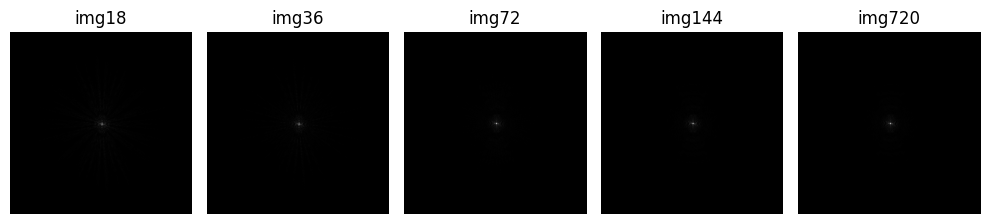

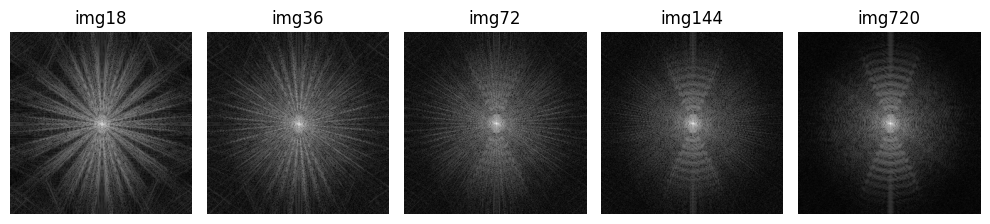

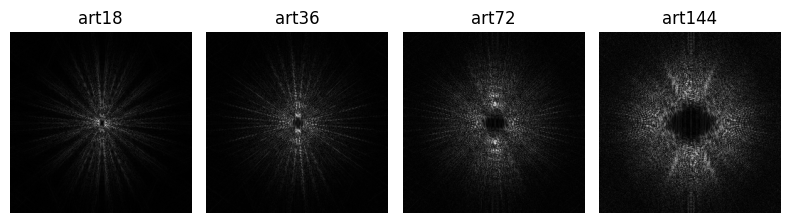

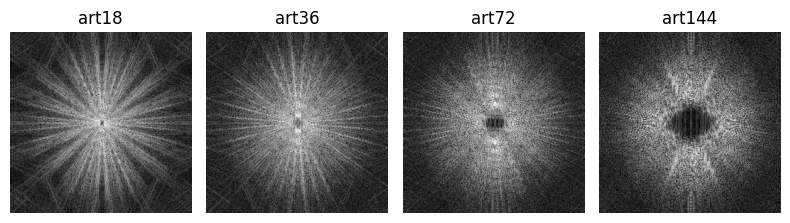

In [5]:
show_multiple_images(1, 5, amp_img_list, titles=['img18', 'img36','img72', 'img144', 'img720'], tight=True, figsize=(10,5))
show_multiple_images(1, 5, logamp_img_list, titles=['img18', 'img36','img72', 'img144', 'img720'], tight=True, figsize=(10,5))
show_multiple_images(1, 4, amp_art_list, titles=['art18', 'art36', 'art72', 'art144'], tight=True, figsize=(8,4))
show_multiple_images(1, 4, logamp_art_list, titles=['art18', 'art36', 'art72', 'art144'], tight=True, figsize=(8,4))

## Sample Gaussian Band-Pass Filter

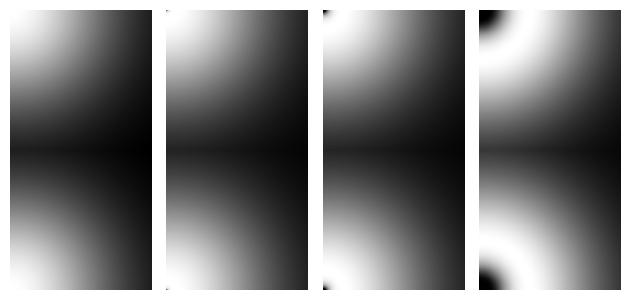

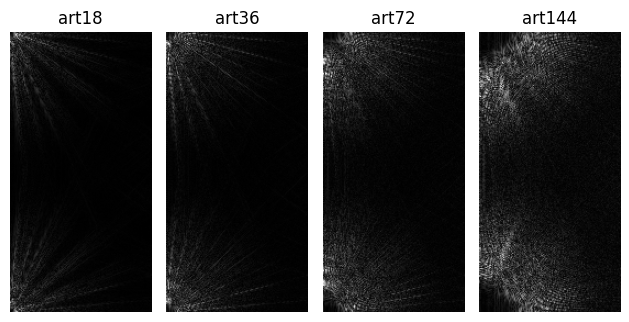

In [12]:
def gen_gaussian_bandpass(center=0, width=0.2, shape=(256, 129), 
    shift_to_fit_fft=True, unsqueeze=True, threshold=False):
    # accept input format: [C, 1]
    def _make_shape(x):
        if not torch.is_tensor(x):
            if not isinstance(x, (tuple, list)):
                x = torch.tensor([x])
            else:
                x = torch.tensor(x)
        if x.ndim <= 3:
            dim = x.numel()
            x = x.reshape(dim, 1, 1)
        return x

    center = _make_shape(center).clamp(0, 1)
    width = _make_shape(width).clamp(min=1e-12, max=2)
    assert center.shape == width.shape, f'center: {center} != width: {width}.'
    X, Y = torch.meshgrid(torch.arange(shape[0]), torch.arange(shape[1]))
    X = torch.repeat_interleave(X.unsqueeze(0), center.shape[0], dim=0).to(center.device)
    Y = torch.repeat_interleave(Y.unsqueeze(0), center.shape[0], dim=0).to(center.device)
    x0 = (shape[0]-1) // 2
    y0 = 0
    D2 = ((X - x0) ** 2 + (Y - y0) ** 2).float()
    D2 /= D2.max()
    H = torch.exp(-((D2 - center ** 2)/(D2.sqrt() * width + 1e-12)) ** 2)
    H = torch.roll(H, H.shape[-2]//2 + 1, -2) if shift_to_fit_fft else H
    H = H.unsqueeze(0) if unsqueeze else H
    if threshold:
        H_mean = H.mean()
        H[H < H_mean] = 0.0
        H[H >= H_mean] = 1.0
    return H

fft_art_list = get_fft_batch(art_list, roll=0, real=True)  # rFFT of artifacts, unrolled
logamp_art_list = get_log_batch(fft_art_list)  # log-amplitudes of artifacts
amp_art_list = get_abs_batch(fft_art_list)  # amplitudes of artifacts

show_multiple_images(1, 4, gen_gaussian_bandpass([0, 0.05, 0.1, 0.25], [0.5, 0.5, 0.5, 0.5]).squeeze(), tight=True)
show_multiple_images(1, 4, amp_art_list, titles=['art18', 'art36', 'art72', 'art144'], tight=True)

## Learned Band-Pass Maps

In [13]:
def check_learned_mask_info(ckpt_path, verbose_mean=True, verbose_std=True):
    ckpt = torch.load(ckpt_path, map_location='cpu')['net_param']
    mask_dict = OrderedDict([(k, v) for (k, v) in ckpt.items() if 'center' in k or 'width' in k])
    centers, widths = [None for _ in range(5)], [None for _ in range(5)]
    centers_mean, widths_mean = [None for _ in range(5)], [None for _ in range(5)]
    centers_std, widths_std = [None for _ in range(5)], [None for _ in range(5)]
    masks = [None for _ in range(5)]
    masks_mean = [None for _ in range(5)]
    masks_std = [None for _ in range(5)]

    centers[0] = (
        mask_dict['inc.1.conv_blocks.ffc.convg2g.fu.center'], 
        mask_dict['inc.1.conv_blocks.ffc.convg2g.fu.center'])
    centers[1] = (
        mask_dict['down_blocks.0.conv.conv_blocks.0.ffc.convg2g.fu.center'],
        mask_dict['down_blocks.0.conv.conv_blocks.1.ffc.convg2g.fu.center'])
    centers[2] = (
        mask_dict['down_blocks.1.conv.conv_blocks.0.ffc.convg2g.fu.center'],
        mask_dict['down_blocks.1.conv.conv_blocks.1.ffc.convg2g.fu.center'])
    centers[3] = (
        mask_dict['down_blocks.2.conv.conv_blocks.0.ffc.convg2g.fu.center'],
        mask_dict['down_blocks.2.conv.conv_blocks.1.ffc.convg2g.fu.center'])
    centers[4] = (
        mask_dict['down_blocks.3.conv.conv_blocks.0.ffc.convg2g.fu.center'],
        mask_dict['down_blocks.3.conv.conv_blocks.1.ffc.convg2g.fu.center'])
    
    widths[0] = (
        mask_dict['inc.1.conv_blocks.ffc.convg2g.fu.width'], 
        mask_dict['inc.1.conv_blocks.ffc.convg2g.fu.width'])
    widths[1] = (
        mask_dict['down_blocks.0.conv.conv_blocks.0.ffc.convg2g.fu.width'],
        mask_dict['down_blocks.0.conv.conv_blocks.1.ffc.convg2g.fu.width'])
    widths[2] = (
        mask_dict['down_blocks.1.conv.conv_blocks.0.ffc.convg2g.fu.width'],
        mask_dict['down_blocks.1.conv.conv_blocks.1.ffc.convg2g.fu.width'])
    widths[3] = (
        mask_dict['down_blocks.2.conv.conv_blocks.0.ffc.convg2g.fu.width'],
        mask_dict['down_blocks.2.conv.conv_blocks.1.ffc.convg2g.fu.width'])
    widths[4] = (
        mask_dict['down_blocks.3.conv.conv_blocks.0.ffc.convg2g.fu.width'],
        mask_dict['down_blocks.3.conv.conv_blocks.1.ffc.convg2g.fu.width'])
    
    for i in range(len(centers)):
        c = torch.cat(centers[i], dim=0)
        w = torch.cat(widths[i], dim=0)
        centers_mean[i] = c.mean()
        widths_mean[i] = w.mean()
        centers_std[i] = c.std()
        widths_std[i] = w.std()
        masks[i] = gen_gaussian_bandpass(c, w).squeeze()
        
        if verbose_mean:
            print(f'MEAN center/width for channels {c.shape[0] // 2}: {centers_mean[i]}/{widths_mean[i]}')
        if verbose_std:
            print(f'STD center/width for channels {c.shape[0] // 2}: {centers_std[i]}/{widths_std[i]}')
        masks_mean[i] = masks[i].mean(dim=0)
        masks_std[i] = masks[i].std(dim=0)
    
    return centers, widths, masks, masks_mean, masks_std

def unshift_mask(x):
    width = x.shape[-1]
    #y = x[..., :width]
    #y = torch.cat((x[..., :width//2], x[..., width//2+1:]), dim=-1)
    y = torch.roll(x, int(x.shape[-2]//2 + 1), -2)
    #y = torch.cat((torch.flip(y, dims=[-1,-2]), y), dim=-1)
    return y

def get_global_average(x_list):
    y = []
    for x in x_list:
        y.append(torch.cat(x, dim=0))
    y = torch.cat(y, dim=0)
    return float(y.mean()), float(y.std())

def rescale(x, y_min=0, y_max=255, x_min=0, x_max=1):
    x_min = x.min() if x_min is None else x_min
    x_max = x.max() if x_max is None else x_max
    slope = (y_max - y_min) / (x_max - x_min)
    intercept = y_max - slope * x_max
    y = slope * x + intercept
    return y


Global (mean,std) center/width: (0.0, 0.0)/(0.9969005584716797, 0.021561555564403534)
--------------------------------
Global (mean,std) center/width: (0.1036553829908371, 0.04972655326128006)/(0.7778289914131165, 0.059075336903333664)
--------------------------------
Global (mean,std) center/width: (0.12132535129785538, 0.03160085156559944)/(0.6350200772285461, 0.025025950744748116)
--------------------------------
Global (mean,std) center/width: (0.19425739347934723, 0.013760910369455814)/(0.6000338196754456, 0.009113220497965813)
--------------------------------


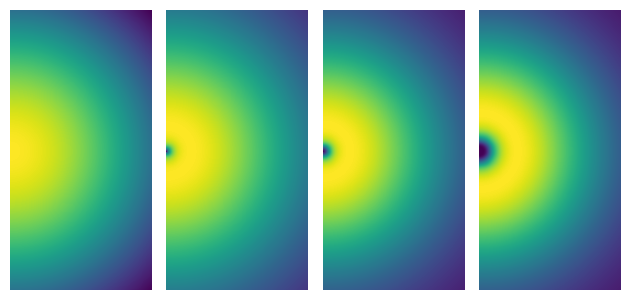

In [19]:
def display_learned_mask(ckpt_path):
    centers, widths, masks, masks_mean, masks_std = check_learned_mask_info(ckpt_path, verbose_mean=False, verbose_std=False)
    masks_mean = [unshift_mask(_) for _ in masks_mean]
    masks_mean_all = torch.stack(masks_mean, dim=0).mean(dim=0)
    print(f'Global (mean,std) center/width: {get_global_average(centers)}/{get_global_average(widths)}')
    print('--------------------------------')
    return masks_mean_all

mask18 = display_learned_mask('/mnt/data_jixie1/clma/freeseed/ckpts/[18]freeseed-free_e29.pth')
mask36 = display_learned_mask('/mnt/data_jixie1/clma/freeseed/ckpts/[36]freeseed-free_e29.pth')
mask72 = display_learned_mask('/mnt/data_jixie1/clma/freeseed/ckpts/[72]freeseed-free_e29.pth')
mask144 = display_learned_mask('/mnt/data_jixie1/clma/freeseed/ckpts/[144]freeseed-free_e29.pth')

show_multiple_images(1, 4, [mask18, mask36, mask72, mask144], tight=True, cmaps=None)
